In [1]:
import nflgame
import matplotlib.pyplot as plt

# returns the field position as the number of yards away from the opposing team's end zone
def field_pos_to_number(pos):
    pos = pos.split(" ")
    if pos[0] == "MIDFIELD":
        return 50
    elif pos[0] == "OWN":
        return 100-int(pos[1])
    elif pos[0] == "OPP":
        return int(pos[1])
    
# returns the current game clock as a quarter, clock tuple
def clock_to_nums(clock):
    clock = clock.split(" ")
    clock[0] = min(int(clock[0][1:]), 5)
    return clock[0], clock[1]

# returns the current play in a different format
def convert_play(p):
    quarter, time = clock_to_nums(p[2])
    return [quarter, time, p[3], p[4], field_pos_to_number(p[5]), p[-5], p[-4], p[-3], p[-2], p[-1]]
    
# get number of points scored on the conversion attempt after a touchdown
def get_conversion(plays, scores, i):
    # use list of scoring plays to figure out conversions
    if i < len(scores):
        #print(scores[i])
        if " TD " in scores[i]:
            if "failed" in scores[i]:
                return 0, i+1
            if "kick is good" in scores[i]:
                return 1, i+1
            if "run)" in scores[i] or "pass)" in scores[i]:
                return 2, i+1
            if i < len(scores)-1 and "defensive two point conversion" in scores[i+1]:
                return -1, i+2
    return 0, i+1

# get all plays for a given game in the proper format
def get_all_plays2(game, spread):   
    plays = nflgame.combine_plays([game])
    scores = game.scores
    score_index = 0
    home = 0
    away = 0
    win = (game.score_home >= game.score_away)
    plays2 = []
    for p in plays:
        plays2.append(p)

    all_plays = []
    for i in range(len(plays2)):
        p = plays2[i]
        if (p.down > 0 and str(p.time) != "None" and str(p.yardline) != "None"): # or p.note == "KICKOFF":
            # add play to all plays
            temp_play = [game.home, game.away, str(p.time), p.down, p.yards_togo, 
                         str(p.yardline), p.home, home, away, spread, win]
            all_plays.append(convert_play(temp_play))
#         if (not p.note == None) and len(p.note) >= 2 and (p.note[:2] == "2P" or p.note[:2] == "XP"):
#             print(p.note)
        # do scoring stuff
        if p.note == "TD":
            pts = 6
            is_home = p.home
            if p.punting_tot == 1:
                is_home = (not is_home)
            if p.defense_tds == 1:
                is_home = (not is_home)
#             is_home = True
#             if (not p.home and p.defense_tds != 1) or (p.home and p.defense_tds == 1):
#                 is_home = False
            conv, score_index = get_conversion(plays2, scores, score_index)
            # add conversion points if it wasn't a defensive 2 point conversion
            if conv != -1:
                pts += conv
            if is_home:
                home += pts
            else:
                away += pts
            # handle defensive 2 point conversion 
            if conv == -1:
                if is_home:
                    away += 2
                else:
                    home += 2
            #print(str(home) + "-" + str(away))

        elif p.note == "FG":
            if p.home:
                home += 3
            else:
                away += 3
            score_index += 1
                
        elif p.note == "SAF":
            if scores[score_index].split("-")[0][:-1] == str(game.home):
                home += 2
            else:
                away += 2
            score_index += 1

    return home, away, all_plays

def fix_name(t):
    if t == "SD":
        t = "LAC"
    if t == "LA" or t == "STL":
        t = "LAR"
    if t == "JAC":
        t = "JAX"
    return t
    
# get all plays from all weeks in weeks and all seasons in years. calls get_all_plays2
def get_plays(years, weeks, indexes=-1):
    all_plays = []
    for y in years:
        print(y)
        for w in weeks:
            #print(w)
            try:
                games = nflgame.games(y, week=w, kind='REG')
            except:
                continue
            current = data[(data["schedule_season"] == y) & (data["schedule_week"] == str(w))]
            if not indexes == -1:
                games = [games[i] for i in indexes]
            for g in games:
                t1 = g.home
                t2 = g.away
                t1 = fix_name(t1)
                t2 = fix_name(t2)
                #print(t2)
                spread = list(current.loc[(current["team1"] == t1) & (current["team2"] == t2)]["vegas_spread"])
                if len(spread) > 0:
                    h, a, cur_plays = get_all_plays2(g, spread[0])
                    if h != g.score_home or a != g.score_away:
                        #print("Actual: " + str(g.score_home) + "-" + str(g.score_away) + ", Mine: " + str(h) + "-" + 
                          #    str(a) + " " + str(g.home) + " " +str(g.away))
                        continue
                    all_plays += cur_plays
    return all_plays

# final model?
def collect_plays(all_plays):
    # collect plays and add interaction terms
    x_data = []
    y_data = []
    for p in all_plays:
        qtr = p[0]
        time = p[1].split(":")
        if len(time[0]) == 0:
            continue
        mins_left = 15*(4-min(qtr,4))+int(time[0])
        secs_left = int(time[1])
        time_left = round(mins_left + secs_left/60.,2)

        x_data.append([time_left]+p[2:-1])
        y_data.append(1 if p[-1] else 0)

    df = pd.DataFrame(x_data, columns=["time", "down", "distance", "fieldpos", "homeposs", "score_home", 
                                      "score_away", "spread"])

    
    df["last5"] = df["time"].apply(lambda x : 1 if x <= 5 else 0)
    
    # basic terms
    df["scorediff"] = (df["score_home"] - df["score_away"])
    df["down1"] = df["down"].apply(lambda x : 1 if x == 1 else 0)
    df["down2"] = df["down"].apply(lambda x : 1 if x == 2 else 0)
    df["down3"] = df["down"].apply(lambda x : 1 if x == 3 else 0)
    df["down4"] = df["down"].apply(lambda x : 1 if x == 4 else 0)
    df["homeposs"] = df["homeposs"].apply(lambda x : 1 if x else 0)
    
    # interaction terms
    df["down1*poss"] = df["down1"] * df["homeposs"] * (1-df["last5"])
    df["down2*poss"] = df["down2"] * df["homeposs"] * (1-df["last5"])
    df["down3*poss"] = df["down3"] * df["homeposs"] * (1-df["last5"])
    df["down4*poss"] = df["down4"] * df["homeposs"] * (1-df["last5"])
    df["distance*poss"] = df["distance"] * df["homeposs"] * (1-df["last5"])
    df["fieldpos*poss"] = df["fieldpos"] * df["homeposs"] * (1-df["last5"])
    
    # time dependent stuff
    # basic terms
    df["scorediff_time"] = (df["score_home"] - df["score_away"]) * df["last5"]
    df["down1_time"] = df["down"].apply(lambda x : 1 if x == 1 else 0) * df["last5"]
    df["down2_time"] = df["down"].apply(lambda x : 1 if x == 2 else 0) * df["last5"]
    df["down3_time"] = df["down"].apply(lambda x : 1 if x == 3 else 0) * df["last5"]
    df["down4_time"] = df["down"].apply(lambda x : 1 if x == 4 else 0) * df["last5"]
    
    # interaction terms
    df["down1*poss_time"] = df["down1"] * df["homeposs"] * df["last5"]
    df["down2*poss_time"] = df["down2"] * df["homeposs"] * df["last5"]
    df["down3*poss_time"] = df["down3"] * df["homeposs"] * df["last5"]
    df["down4*poss_time"] = df["down4"] * df["homeposs"] * df["last5"]
    df["distance*poss_time"] = df["distance"] * df["homeposs"] * df["last5"]
    df["fieldpos*poss_time"] = df["fieldpos"] * df["homeposs"] * df["last5"]
    
    # more interaction terms
    df["time*poss"] = (60-df["time"]) * df["homeposs"]
    df["time*spread"] = df["time"] * df["spread"]
    df["time*scorediff"] = (60-df["time"]) * df["scorediff"]
    df["fgrange"] = df["fieldpos"].apply(lambda x : 1 if x <= 35 else 0)
    df["fgrange*poss"] = df["fgrange"] * df["homeposs"]

    # additional terms
    df["close"] = df["scorediff"].apply(lambda x : 1 if abs(x) <= 8 else 0)
    df["last5min_close"] = df["last5"] * df["close"]
    df["last5min_close_poss"] = df["last5min_close"] * df["homeposs"]
    
    # fix basic terms
    df["scorediff"] *= (1-df["last5"])
    df["down1"] *= (1-df["last5"])
    df["down2"] *= (1-df["last5"])
    df["down3"] *= (1-df["last5"])
    df["down4"] *= (1-df["last5"])
    df["homeposs"] *= (1-df["last5"])
    
    # score correction
    df["sqrt_time"] = df["time"].apply(lambda x : 1 + np.sqrt(x))
    df["score_correction"] = df["scorediff"] / df["sqrt_time"]
    
    df.drop(["score_correction", "homeposs", "down", "score_home", "score_away", "last5", 
             "close", "sqrt_time", "last5min_close", "last5min_close_poss"], axis=1, inplace=True)
    
    return df, y_data

def remove_features(df):
    df.drop(["time*poss", "time*spread", "time*scorediff", "fgrange", "fgrange*poss"], axis=1, inplace=True)
    return df

def check_wp(x, y, model, threshold):
    y_pred = model.predict(x)
    
    results = []
    for i in range(len(y_pred)):
        if abs(y_pred[i]-threshold) <= 0.01:
            if y[i] == 1:
                results.append(1)
            else:
                results.append(0)
    #print(count)
    m = np.mean(results)
    return m, np.sqrt(m*(1-m)/len(results))

def check_wp2(x, y, model, threshold):
    y_pred = model.predict(x)
    time_left = list(x["time"])
    
    results = []
    for i in range(len(y_pred)):
        if time_left[i] > 5:
            continue
        if abs(y_pred[i]-threshold) <= 0.01:
            if y[i] == 1:
                results.append(1)
            else:
                results.append(0)
    #print(count)
    m = np.mean(results)
    return m, np.sqrt(m*(1-m)/len(results))

# check accuracy using original mse thing
def check_model_accuracy(test_x, test_y, model, last5):
    x = np.arange(0,1.01,0.05)
    y = []
    ses = []
    se = 0
    for i in x:
        if not last5:
            cur_mean, cur_se = check_wp(test_x, test_y, model, i)
        else:
            cur_mean, cur_se = check_wp2(test_x, test_y, model, i)
        y.append(cur_mean)
        ses.append(cur_se)
        print(str(round(i,2)) + ": " + str(round(cur_mean,3)) + ", SE = " + str(round(cur_se, 3)))
        se += (cur_mean-i)**2

    print("")
    print("mse: " + str(se/len(x)))

    plt.close()
    plt.plot(x,x) # for reference
    plt.plot(x,y)
    plt.xlabel("k")
    plt.ylabel("Winning probability")
    #plt.savefig("/Users/Bill/Documents/Fall 2019/THesis/interimreport/plot1.png")
    plt.show()
    
# check accuracy using the brier score
def check_model_accuracy2(test_x, test_y, model):
    x = np.arange(0,1.01,0.05)
    y = []
    se = 0
    count = 0
    for i in x:
        cur_mean, cur_se, cur_num = get_brier(test_x, test_y, model, i)
        y.append(cur_mean)
        print(str(round(i,2)) + ": " + str(round(cur_mean,3)))
        se += cur_se
        count += cur_num

    print("")
    print("brier score: " + str(se/count))

    plt.close()
    plt.plot(x,x) # for reference
    plt.plot(x,y)
    plt.xlabel("k")
    plt.ylabel("Winning probability")
    #plt.savefig("/Users/Bill/Documents/Fall 2019/THesis/interimreport/plot1.png")
    plt.show()
    
def get_brier(x, y, model, threshold):
    y_pred = model.predict(x)
    
    results = []
    errors = []
    
    y_pred = list(y_pred)
    for i in range(len(y_pred)):
        if abs(y_pred[i]-threshold) <= 0.025:
            if y[i] == 1:
                results.append(1)
            else:
                results.append(0)
            errors.append((y[i]-y_pred[i])**2)
    #print(count)
    return np.mean(results), sum(errors), len(errors)

# check accuracy using the brier score
def check_model_accuracy_all(test_x, test_y, model):
    x = np.arange(0,1.01,0.05)
    y = []
    brier = 0
    se = 0
    count = 0
    for i in x:
        cur_mean, cur_brier, cur_num = get_brier(test_x, test_y, model, i)
        y.append(cur_mean)
        print(str(round(i,2)) + ": " + str(round(cur_mean,3)))
        brier += cur_brier
        se += (cur_mean-i)**2
        count += cur_num

    print("")
    print("mse: " + str(se/len(x)))
    print("brier score: " + str(brier/count))

    plt.close()
    plt.plot(x,x) # for reference
    plt.plot(x,y)
    plt.xlabel("k")
    plt.ylabel("Winning probability")
    #plt.savefig("/Users/Bill/Documents/Fall 2019/THesis/interimreport/plot1.png")
    plt.show()
    
# check accuracy using the brier score
def check_model_accuracy_times(old_test_x, old_test_y, model, start_time, end_time):
    indices = old_test_x.index[(old_test_x["time"] <= start_time) & (old_test_x["time"] >= end_time)].tolist()
    test_x = old_test_x.loc[indices, :]
    test_y = [old_test_y[i] for i in indices]
    
    #print(test_x.head())
    
    x = np.arange(0,1.01,0.05)
    y = []
    brier = 0
    se = 0
    count = 0
    for i in x:
        cur_mean, cur_brier, cur_num = get_brier(test_x, test_y, model, i)
        y.append(cur_mean)
        print(str(round(i,2)) + ": " + str(round(cur_mean,3)))# + ", brier: " + str(round(cur_brier/cur_num, 3)))
        brier += cur_brier
        se += (cur_mean-i)**2
        count += cur_num

    print("")
    print("mse: " + str(se/len(x)))
    print("brier score: " + str(brier/count))

    plt.close()
    plt.plot(x,x) # for reference
    plt.plot(x,y)
    plt.xlabel("k")
    plt.ylabel("Winning probability")
    #plt.savefig("/Users/Bill/Documents/Fall 2019/THesis/interimreport/plot1.png")
    plt.show()
    
# check accuracy using the brier score
def check_model_accuracy_times_pca(old_old_test_x, old_test_x, old_test_y, model, start_time, end_time):
    indices = old_test_x.index[(old_old_test_x["time"] <= start_time) & 
                               (old_old_test_x["time"] >= end_time)].tolist()
    test_x = old_test_x.loc[indices, :]
    test_y = [old_test_y[i] for i in indices]
    
    #print(test_x.head())
    
    x = np.arange(0,1.01,0.05)
    y = []
    brier = 0
    se = 0
    count = 0
    for i in x:
        cur_mean, cur_brier, cur_num = get_brier(test_x, test_y, model, i)
        y.append(cur_mean)
        print(str(round(i,2)) + ": " + str(round(cur_mean,3)))# + ", brier: " + str(round(cur_brier/cur_num, 3)))
        brier += cur_brier
        se += (cur_mean-i)**2
        count += cur_num

    print("")
    print("mse: " + str(se/len(x)))
    print("brier score: " + str(brier/count))

    plt.close()
    plt.plot(x,x) # for reference
    plt.plot(x,y)
    plt.xlabel("k")
    plt.ylabel("Winning probability")
    #plt.savefig("/Users/Bill/Documents/Fall 2019/THesis/interimreport/plot1.png")
    plt.show()

# check accuracy using the brier score and does the binary prediction thing
def check_model_accuracy_times2(old_test_x, old_test_y, model, start_time, end_time):
    indices = old_test_x.index[(old_test_x["time"] <= start_time) & (old_test_x["time"] >= end_time)].tolist()
    test_x = old_test_x.loc[indices, :]
    test_y = [old_test_y[i] for i in indices]
    
    #print(test_x.head())
    
    x = np.arange(0,1.01,0.05)
    y = []
    brier = 0
    se = 0
    count = 0
    for i in x:
        cur_mean, cur_brier, cur_num = get_brier(test_x, test_y, model, i)
        y.append(cur_mean)
        print(str(round(i,2)) + ": " + str(round(cur_mean,3)))# + ", brier: " + str(round(cur_brier/cur_num, 3)))
        brier += cur_brier
        se += (cur_mean-i)**2
        count += cur_num
        
    # do binary thing
    y_pred = model.predict(test_x)
    b_y_pred = [1 if val > 0.5 else 0 for val in y_pred]
    correct = 0
    for i in range(len(b_y_pred)):
        if b_y_pred[i] == test_y[i]:
            correct += 1

    print("")
    print("mse: " + str(se/len(x)))
    print("brier score: " + str(brier/count))
    print("binary prediction accuracy: " + str(correct/len(b_y_pred)))

    plt.close()
    plt.plot(x,x) # for reference
    plt.plot(x,y)
    plt.xlabel("k")
    plt.ylabel("Winning probability")
    fig = plt.gcf()
    #plt.savefig("/Users/Bill/Documents/Fall 2019/THesis/interimreport/plot1.png")
    plt.show()
    return fig

In [2]:
import pandas as pd
import random
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

# get spread data
data = pd.read_csv("elo_and_vegas_spreads2.csv")

data = data.drop(data.columns[0], axis=1)
data = data[data["schedule_season"] >= 2009]
data = data[data["schedule_playoff"] == False]
data.drop(["schedule_playoff"],axis=1,inplace=True)

# get training and testing data
test_fraction = 0.3

years = [i for i in range(2009,2019)]
weeks = [i for i in range(1,18)]
plays = []
for y in years:
    plays.append(get_plays([y],weeks))

/Users/Bill/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


2009
2010
2011
2012
2013
2014
2015
2016
2017
2018


In [3]:
x_data = []
y_data = []
for i in range(len(plays)):
    x_data_cur, y_data_cur = collect_plays(plays[i])
    x_data.append(x_data_cur)
    y_data.append(y_data_cur)
    
train_x = []
test_x = []
train_y = []
test_y = []

for i in range(len(x_data)):
    cur_x = pd.concat([x_data[j] for j in range(len(x_data)) if j != i])
    cur_y = [y_data[j] for j in range(len(y_data)) if j != i]
    cur_y = [val for ylist in cur_y for val in ylist]
    train_x.append(cur_x)
    train_y.append(cur_y)
    test_x.append(x_data[i])
    test_y.append(y_data[i])

cols = list(train_x[0])
train_x2 = []
test_x2 = []
for i in range(len(train_x)):
    temp = pd.DataFrame(data=np.array(train_x[i]), columns=cols)
    train_x2.append(remove_features(temp))
    temp2 = pd.DataFrame(data=np.array(test_x[i]), columns=cols)
    test_x2.append(remove_features(temp2))


In [4]:
means1 = []
briers1 = []
means2 = []
briers2 = []
counts1 = [0 for i in range(21)]
counts2 = [0 for i in range(21)]
cv_means1 = []
cv_means2 = []
cv_briers1 = []
cv_briers2 = []

results1 = []
results2 = []

for i in range(len(train_x)):
    print(i)
    logit_model=sm.Logit(train_y[i], train_x[i])
    result=logit_model.fit()
    results1.append(result)
    
    logit_model=sm.Logit(train_y[i], train_x2[i])
    result=logit_model.fit()
    results2.append(result)

0
Optimization terminated successfully.
         Current function value: 0.448842
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.452669
         Iterations 8
1
Optimization terminated successfully.
         Current function value: 0.447119
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.451318
         Iterations 8
2
Optimization terminated successfully.
         Current function value: 0.443935
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.447958
         Iterations 8
3
Optimization terminated successfully.
         Current function value: 0.446527
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.450675
         Iterations 9
4
Optimization terminated successfully.
         Current function value: 0.445308
         Iterations 8
Optimization terminated successfully.
         Current function value: 0

In [5]:
import math

# check accuracy using the brier score
def check_model_accuracy_times3(old_test_x, old_test_y, model, start_time, end_time):
    indices = old_test_x.index[(old_test_x["time"] <= start_time) & (old_test_x["time"] >= end_time)].tolist()
    test_x = old_test_x.loc[indices, :]
    test_y = [old_test_y[i] for i in indices]
    
    #print(test_x.head())
    
    x = np.arange(0,1.01,0.05)
    y = []
    brier = 0
    counts = []
    means = []
    for i in x:
        cur_mean, cur_brier, cur_num = get_brier(test_x, test_y, model, i)
        y.append(cur_mean * cur_num)
        brier += cur_brier
        counts.append(cur_num)

    return y, brier, counts

def check_accuracy_lock_nettleton(x, y, model, start, end):
    cur_means, cur_brier, cur_count = check_model_accuracy_times3(x, y, model, start, end)
    
    return cur_means, cur_brier, cur_count, list(np.divide(np.array(cur_means), np.array(cur_count))), \
        cur_brier / sum(cur_count)

def check_accuracy_lock_nettleton_wrapper(test_x, test_y, results, start, end):
    means1 = []
    briers1 = []
    counts1 = [0 for i in range(21)]
    cv_means1 = []
    cv_briers1 = []

    for i in range(len(test_x)):
        cur1, cur2, cur3, cur4, cur5 = check_accuracy_lock_nettleton(test_x[i], test_y[i], results[i], start, end)
        means1.append(cur1)
        briers1.append(cur2)
        counts1 = list(np.array(counts1) + np.array(cur3))
        cv_means1.append(cur4)
        cv_briers1.append(cur5)

    # model 1
    x = np.arange(0, 1.01, 0.05)

    ses1 = [0 for i in range(len(cv_means1))]
    count1 = 0
    for i in range(len(cv_means1)):
        for j in range(len(cv_means1[i])):
            if math.isnan(cv_means1[i][j]):
                continue
            ses1[i] += (cv_means1[i][j]-x[j])**2
            count1 += 1
        ses1[i] = ses1[i] / count1
        count1 = 0

    print("average mse: " + str(sum(ses1)/(len(cv_means1))))
    print("average brier score: " + str(sum(cv_briers1)/len(cv_briers1)))
    print("")
    
def check_accuracy_lock_nettleton_wrapper2(test_x, test_y, results, start, end, filename_start):
    means1 = []
    briers1 = []
    counts1 = [0 for i in range(21)]
    cv_means1 = []
    cv_briers1 = []

    for i in range(len(test_x)):
        cur1, cur2, cur3, cur4, cur5 = check_accuracy_lock_nettleton(test_x[i], test_y[i], results[i], start, end)
        means1.append(cur1)
        briers1.append(cur2)
        counts1 = list(np.array(counts1) + np.array(cur3))
        cv_means1.append(cur4)
        cv_briers1.append(cur5)

    # model 1
    x = np.arange(0, 1.01, 0.05)

    ses1 = [0 for i in range(len(cv_means1))]
    count1 = 0
    for i in range(len(cv_means1)):
        for j in range(len(cv_means1[i])):
            if math.isnan(cv_means1[i][j]):
                continue
            ses1[i] += (cv_means1[i][j]-x[j])**2
            count1 += 1
        ses1[i] = ses1[i] / count1
        count1 = 0

    print("average mse: " + str(sum(ses1)/(len(cv_means1))))
    print("average brier score: " + str(sum(cv_briers1)/len(cv_briers1)))
    print("")
    
    for i in range(len(cv_means1)):
        print(years[i])
        print("mse: " + str(sum([(cv_means1[i][j]-x[j])**2 for j in range(len(x))]) / len(x)))
        print("brier: " + str(cv_briers1[i]))
        plt.close()
        plt.plot(x,x) # for reference
        plt.plot(x,cv_means1[i])
        plt.xlabel("k")
        plt.ylabel("Winning probability")
        plt.title("omitted season: " + str(years[i]))
        #plt.savefig("/Users/Bill/Documents/Fall 2019/THesis/thesis/Figures/logistic_time/byseason/"+filename_start+
         #           str(years[i])+"_last5.png")
        plt.show()

In [6]:
result = results1[0].params.values
for i in range(1, len(results1)):
    for j in range(len(results1[i].params.values)):
        result[j] += results1[i].params.values[j]

result = result / len(results1)
print(result)

[ 3.23177983e-03  6.84087699e-03  7.46813419e-03 -7.00855853e-02
  8.28225854e-02 -8.56283247e-01 -7.84896832e-01 -7.05488466e-01
 -5.31322643e-01  1.31891309e+00  1.17073258e+00  9.90281971e-01
  6.52167387e-01 -1.50732306e-02 -1.49917311e-02  2.20609644e-01
 -1.11377812e+00 -1.04880061e+00 -9.15977524e-01 -5.28419131e-01
  2.85232640e+00  2.63250767e+00  2.32854765e+00  1.58229220e+00
 -2.79508261e-02 -2.96675884e-02  7.23107495e-03 -1.39797935e-03
  2.40168494e-03 -9.56639953e-02  1.28333229e-01]


In [7]:
# get all plays from all weeks in weeks and all seasons in years. calls get_all_plays2
def get_plays2(years, weeks, indexes=-1):
    all_plays = []
    for y in years:
        print(y)
        for w in weeks:
            try:
                games = nflgame.games(y, week=w, kind='POST')
            except:
                continue
            for g in games:
                print(g)
            current = data[(data["schedule_season"] == y) & (data["schedule_week"] == str(w))]
            if not indexes == -1:
                games = [games[i] for i in indexes]
            for g in games:
                t1 = g.home
                t2 = g.away
                t1 = fix_name(t1)
                t2 = fix_name(t2)
                #print(t2)
                spread = list(current.loc[(current["team1"] == t1) & (current["team2"] == t2)]["vegas_spread"])
                if len(spread) > 0:
                    h, a, cur_plays = get_all_plays2(g, spread[0])
                    if h != g.score_home or a != g.score_away:
                        #print("Actual: " + str(g.score_home) + "-" + str(g.score_away) + ", Mine: " + str(h) + "-" + 
                          #    str(a) + " " + str(g.home) + " " +str(g.away))
                        continue
                    all_plays += cur_plays
    return all_plays

In [8]:
games = nflgame.games(2016, 5, kind='POST')
h, a, sb = get_all_plays2(games[0], 3)

In [9]:
sb

[[1, '15:00', 1, 10, 75, False, 0, 0, 3, False],
 [1, '14:55', 2, 10, 75, False, 0, 0, 3, False],
 [1, '14:26', 3, 1, 66, False, 0, 0, 3, False],
 [1, '13:47', 4, 1, 66, False, 0, 0, 3, False],
 [1, '13:37', 1, 10, 92, True, 0, 0, 3, False],
 [1, '12:55', 1, 10, 55, True, 0, 0, 3, False],
 [1, '12:16', 2, 7, 52, True, 0, 0, 3, False],
 [1, '11:32', 3, 5, 50, True, 0, 0, 3, False],
 [1, '10:41', 4, 15, 60, True, 0, 0, 3, False],
 [1, '10:28', 1, 10, 90, False, 0, 0, 3, False],
 [1, '09:56', 2, 8, 88, False, 0, 0, 3, False],
 [1, '09:22', 1, 10, 75, False, 0, 0, 3, False],
 [1, '08:38', 1, 10, 60, False, 0, 0, 3, False],
 [1, '07:56', 2, 8, 58, False, 0, 0, 3, False],
 [1, '07:15', 3, 1, 51, False, 0, 0, 3, False],
 [1, '06:36', 1, 10, 40, False, 0, 0, 3, False],
 [1, '05:55', 2, 18, 48, False, 0, 0, 3, False],
 [1, '05:48', 3, 18, 48, False, 0, 0, 3, False],
 [1, '05:14', 4, 19, 49, False, 0, 0, 3, False],
 [1, '05:08', 1, 10, 88, True, 0, 0, 3, False],
 [1, '04:25', 2, 1, 79, True, 0, 

In [58]:
sb_x, sb_y = collect_plays(sb)

In [122]:
sb_x

,time,distance,fieldpos,spread,scorediff,down1,down2,down3,down4,down1*poss,...,down2*poss_time,down3*poss_time,down4*poss_time,distance*poss_time,fieldpos*poss_time,time*poss,time*spread,time*scorediff,fgrange,fgrange*poss
0,60.00,10,75,3,0,1,0,0,0,0,...,0,0,0,0,0,0.00,180.00,0.00,0,0
1,59.92,10,75,3,0,0,1,0,0,0,...,0,0,0,0,0,0.00,179.76,0.00,0,0
2,59.43,1,66,3,0,0,0,1,0,0,...,0,0,0,0,0,0.00,178.29,0.00,0,0
3,58.78,1,66,3,0,0,0,0,1,0,...,0,0,0,0,0,0.00,176.34,0.00,0,0
4,58.62,10,92,3,0,1,0,0,0,1,...,0,0,0,0,0,1.38,175.86,0.00,0,0
5,57.92,10,55,3,0,1,0,0,0,1,...,0,0,0,0,0,2.08,173.76,0.00,0,0
6,57.27,7,52,3,0,0,1,0,0,0,...,0,0,0,0,0,2.73,171.81,0.00,0,0
7,56.53,5,50,3,0,0,0,1,0,0,...,0,0,0,0,0,3.47,169.59,0.00,0,0
8,55.68,15,60,3,0,0,0,0,1,0,...,0,0,0,0,0,4.32,167.04,0.00,0,0
9,55.47,10,90,3,0,1,0,0,0,0,...,0,0,0,0,0,0.00,166.41,0.00,0,0


In [67]:
diff = list(sb_x["scorediff"])
for i in range(1, len(diff)):
    if diff[i] != diff[i-1]:
        print(str(i) + ": " + str(diff[i]))

35: 7
44: 14
59: 21
70: 18
87: 25
100: 19
118: 16
126: 8
128: 0


In [99]:
f = []
for i in range(len(sb_x)):
    temp = list(sb_x.iloc[i])
    f.append(sum(result * np.array(temp)))

In [100]:
preds = []
for i in range(len(f)):
    preds.append(1/(1+math.exp(-f[i])))

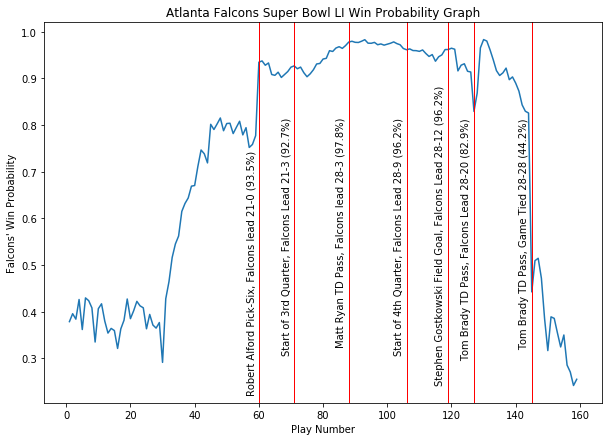

In [167]:
x = np.arange(1, 160, 1)
plt.plot(x, preds)
fig = plt.gcf()
fig.set_size_inches(10, 7)
plt.title("Atlanta Falcons Super Bowl LI Win Probability Graph")
plt.ylabel("Falcons' Win Probability")
plt.xlabel("Play Number")


plt.axvline(60, color='r', linestyle='solid', linewidth=1)
plt.text(56, .73, 'Robert Alford Pick-Six, Falcons lead 21-0 (' + str(round(100*preds[59], 1)) + '%)', rotation='vertical')

plt.axvline(71, color='r', linestyle='solid', linewidth=1)
plt.text(67, .8, 'Start of 3rd Quarter, Falcons Lead 21-3 (' + str(round(100*preds[70], 1)) + '%)', rotation='vertical')

plt.axvline(88, color='r', linestyle='solid', linewidth=1)
plt.text(84, .8, 'Matt Ryan TD Pass, Falcons lead 28-3 (' + str(round(100*preds[87], 1)) + '%)', rotation='vertical')

plt.axvline(106, color='r', linestyle='solid', linewidth=1)
plt.text(102, .8, 'Start of 4th Quarter, Falcons Lead 28-9 (' + str(round(100*preds[105], 1)) + '%)', rotation='vertical')

plt.axvline(119, color='r', linestyle='solid', linewidth=1)
plt.text(115, .87, 'Stephen Gostkowski Field Goal, Falcons Lead 28-12 (' + str(round(100*preds[118], 1)) + '%)', rotation='vertical')

plt.axvline(127, color='r', linestyle='solid', linewidth=1)
plt.text(123, .8, 'Tom Brady TD Pass, Falcons Lead 28-20 (' + str(round(100*preds[126], 1)) + '%)', rotation='vertical')

plt.axvline(145, color='r', linestyle='solid', linewidth=1)
plt.text(141, .8, 'Tom Brady TD Pass, Game Tied 28-28 (' + str(round(100*preds[144], 1)) + '%)', rotation='vertical')

plt.savefig("/Users/Bill/Documents/Fall 2019/THesis/thesis/Figures/winprob.png")
plt.show()

## pats at home

In [12]:
games = nflgame.games(2016, 5, kind='POST')
h, a, sb = get_all_plays2(games[0], -3)

In [13]:
sb[:10]

[[1, '15:00', 1, 10, 75, False, 0, 0, -3, False],
 [1, '14:55', 2, 10, 75, False, 0, 0, -3, False],
 [1, '14:26', 3, 1, 66, False, 0, 0, -3, False],
 [1, '13:47', 4, 1, 66, False, 0, 0, -3, False],
 [1, '13:37', 1, 10, 92, True, 0, 0, -3, False],
 [1, '12:55', 1, 10, 55, True, 0, 0, -3, False],
 [1, '12:16', 2, 7, 52, True, 0, 0, -3, False],
 [1, '11:32', 3, 5, 50, True, 0, 0, -3, False],
 [1, '10:41', 4, 15, 60, True, 0, 0, -3, False],
 [1, '10:28', 1, 10, 90, False, 0, 0, -3, False]]

In [16]:
for p in sb:
    temp = p[-5]
    temp2 = p[-4]
    temp3 = p[-3]
    p[-5] = not temp
    p[-4] = temp3
    p[-3] = temp2

In [20]:
sb_x, sb_y = collect_plays(sb)

In [21]:
f = []
for i in range(len(sb_x)):
    temp = list(sb_x.iloc[i])
    f.append(sum(result * np.array(temp)))

In [22]:
preds = []
for i in range(len(f)):
    preds.append(1/(1+math.exp(-f[i])))

In [28]:
preds = list(1-np.array(preds))

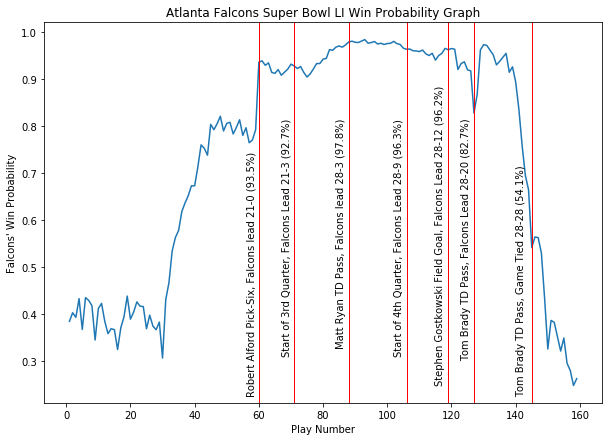

In [32]:
x = np.arange(1, 160, 1)
plt.plot(x, preds)
fig = plt.gcf()
fig.set_size_inches(10, 7)
plt.title("Atlanta Falcons Super Bowl LI Win Probability Graph")
plt.ylabel("Falcons' Win Probability")
plt.xlabel("Play Number")


plt.axvline(60, color='r', linestyle='solid', linewidth=1)
plt.text(56, .73, 'Robert Alford Pick-Six, Falcons lead 21-0 (' + str(round(100*preds[59], 1)) + '%)', rotation='vertical')

plt.axvline(71, color='r', linestyle='solid', linewidth=1)
plt.text(67, .8, 'Start of 3rd Quarter, Falcons Lead 21-3 (' + str(round(100*preds[70], 1)) + '%)', rotation='vertical')

plt.axvline(88, color='r', linestyle='solid', linewidth=1)
plt.text(84, .8, 'Matt Ryan TD Pass, Falcons lead 28-3 (' + str(round(100*preds[87], 1)) + '%)', rotation='vertical')

plt.axvline(106, color='r', linestyle='solid', linewidth=1)
plt.text(102, .8, 'Start of 4th Quarter, Falcons Lead 28-9 (' + str(round(100*preds[105], 1)) + '%)', rotation='vertical')

plt.axvline(119, color='r', linestyle='solid', linewidth=1)
plt.text(115, .87, 'Stephen Gostkowski Field Goal, Falcons Lead 28-12 (' + str(round(100*preds[118], 1)) + '%)', rotation='vertical')

plt.axvline(127, color='r', linestyle='solid', linewidth=1)
plt.text(123, .8, 'Tom Brady TD Pass, Falcons Lead 28-20 (' + str(round(100*preds[126], 1)) + '%)', rotation='vertical')

plt.axvline(145, color='r', linestyle='solid', linewidth=1)
plt.text(140, .7, 'Tom Brady TD Pass, Game Tied 28-28 (' + str(round(100*preds[144], 1)) + '%)', rotation='vertical')

plt.savefig("/Users/Bill/Documents/Fall 2019/THesis/thesis/Figures/winprob.png")
plt.show()